In [1]:
import cadquery as cq 
from jupyter_cadquery import (
    open_viewer, show,
    set_defaults, get_defaults, 
)

from cadquery_massembly import Mate, MAssembly, relocate

# remove "clean" to avoid errors OCP kernel error
cq.occ_impl.shapes.Shape.clean = lambda x: x

cv = open_viewer("DiskArm", cad_width=640, height=500, theme="light")

Overwriting auto display for cadquery Workplane and Shape
Overwriting auto display for build123d BuildPart, BuildSketch, BuildLine, ShapeList
`cad_width` cannot be smaller than 780, setting to 780


In [2]:
set_defaults(axes=False, axes0=True, mate_scale=4)


mate_scale is deprecated, use helper_scale instead



In [3]:
from math import pi, sin, cos, sqrt, asin, degrees, radians
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline

# Disk and Arm

## Model

![disk-arm](1-disk-arm.png)

In [4]:
r_disk = 100
dist_pivot = 200

def angle_arm(angle_disk):
    ra = np.deg2rad(angle_disk)
    v = np.array((dist_pivot, 0)) - r_disk * np.array((cos(ra), sin(ra)))
    return np.rad2deg(np.arctan2(*v[::-1]))

## Visualisation

In [5]:
def diagram(da, aa, i1, i2):
    a1, a2 = radians(da), radians(aa)
    r1, r2 = r_disk, dist_pivot + r_disk
    x1, y1 = (0, r1 * cos(a1)), (0, r1 * sin(a1))
    x2, y2 = (dist_pivot, dist_pivot - r2 * cos(a2)), (0, -r2 * sin(a2))

    ax = fig.add_subplot(spec[i1, i2])
    ax.set_ylim(-r_disk-10, r_disk+10)
    ax.set_title(f"a={da}")

    ax.plot((0, dist_pivot), (0,0), color="lightgrey")
    ax.plot(x1, y1)
    ax.plot(x2, y2, ":")
    
    circle = plt.Circle((0,0), 100, fill=False, color="lightgrey", linestyle='--')
    ax.add_patch(circle)

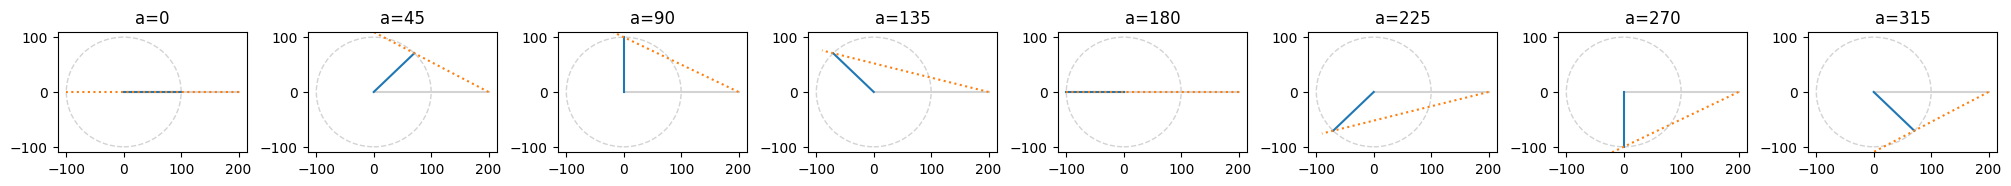

In [6]:
disk_angles = range(0, 360, 45)
arm_angles = [angle_arm(d) for d in disk_angles]

fig = plt.figure(constrained_layout=True)
fig.set_size_inches(20, 1.75)
spec = gridspec.GridSpec(ncols=8, nrows=1, figure=fig)

for i, (da, aa) in enumerate(zip(disk_angles, arm_angles)):
    diagram(da, aa, 0, i)

# Assembly

## Parts

In [7]:
thickness = 5
nr = 5

disk = cq.Workplane().circle(r_disk + 2 * nr).extrude(thickness)
nipple = cq.Workplane().circle(nr).extrude(thickness)
disk = (
    disk
    .cut(nipple)
    .union(nipple.translate((r_disk, 0, thickness)))
)

pivot_base = cq.Workplane().circle(2*nr).extrude(thickness)
base = (
    cq.Workplane()
    .rect(6 * nr + dist_pivot, 6 * nr)
    .extrude(thickness)
    .translate((dist_pivot / 2, 0, 0))
    .union(nipple.translate((dist_pivot, 0, thickness)))
    .union(pivot_base.translate((0, 0, thickness)))
    .union(nipple.translate((0, 0, 2*thickness)))
    .edges("|Z").fillet(3)
)
base.faces(">Z[-2]").wires(cq.NearestToPointSelector((dist_pivot + r_disk, 0))).tag("mate")

slot = (cq.Workplane()
    .rect(2*r_disk, 2*nr)
    .extrude(thickness)
    .union(nipple.translate((-r_disk, 0, 0)))
    .union(nipple.translate((r_disk, 0, 0)))
    .translate((dist_pivot, 0, 0))
)
                                                                        
arm = (
    cq.Workplane()
    .rect(4 * nr + (r_disk + dist_pivot), 4 * nr)
    .extrude(thickness)
    .edges("|Z").fillet(3)    
    .translate(((r_disk + dist_pivot) / 2, 0, 0))
    .cut(nipple)
    .cut(slot)
)
arm.faces(">Z").wires(cq.NearestToPointSelector((0,0))).tag("mate")

show(
    disk,
    base.translate((0, -1.5 * r_disk, 0)),
    arm.translate((0, 1.5 * r_disk, 0)),
)

+++


## Define assembly

In [8]:
import webcolors

def create_disk_arm():
    L = lambda *args: cq.Location(cq.Vector(*args))

    return (MAssembly(base, name="base", color="silver", loc=L(-dist_pivot/2, 0, 0))
        .add(disk, name="disk", color="MediumAquaMarine", loc=L(r_disk, -1.5 * r_disk, 0))
        .add(arm,  name="arm",  color="orange", loc=L(0,  10*nr, 0))
    )

## Define mates

In [9]:
from collections import OrderedDict as odict

disk_arm = create_disk_arm()

disk_arm.mate("base?mate", name="disk_pivot", origin=True, transforms=odict(rz=180))
disk_arm.mate("base@faces@>Z", name="arm_pivot")
disk_arm.mate("disk@faces@>Z[-2]", name="disk", origin=True)
disk_arm.mate("arm?mate", name="arm", origin=True)

show(disk_arm, render_mates=True)

+c+


## Relocate and assemble

In [10]:
# ensure all parts are relocated so that the origin mates is the part origin 
disk_arm.relocate()

# assemble each part
disk_arm.assemble("arm", "arm_pivot")
disk_arm.assemble("disk", "disk_pivot")

d = show(disk_arm, render_mates=True, axes=False)

+++


# Animate

In [11]:
from jupyter_cadquery import AnimationTrack

times = np.linspace(0, 5, 181)
disk_angles = np.linspace(0, 360, 181)
arm_angles = [angle_arm(d) for d in disk_angles]

# move disk
# Note, the selector must follow the path in the CAD view navigation hierarchy
d.add_track(AnimationTrack(f"/base/disk", "rz", times, disk_angles))

# move arm
d.add_track(AnimationTrack(f"/base/arm", "rz", times, arm_angles))

d.animate(speed=2)